In [1]:
import pandas as pd
import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt

import scipy
import scipy.integrate
from scipy.misc import derivative
#from scipy import integrate 

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FFMpegWriter

# Just for the Window Pop Out thing for WINDOWS
# %matplotlib qt

<B>Revised Data From Kepler 11</B>

In [2]:
K11Data = pd.read_csv('Kepler11Data.csv', header=None)

<b>Properties Needed From CSV:</b>  
Orbital Period (Days)   
Orbital Semi-Major Axis (au)  
Planet Radius (Earth radii)  
Planet Mass (Earth mass)  
Orbit Eccentricity (NO UNITS)  
Stellar Mass (Solar Mass)

--------------
<b>Probably Not Useful (all values are the same)</b>
  
Distance fom earth (Parsecs)  
RA (degrees)  
Dec (degrees) n

--------------------------------------------------------------

In [3]:
K11Data

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_controv_flag,pl_orbper,pl_orbpererr1,...,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
1,Kepler-11 b,Kepler-11,1,6,Transit,2010,Kepler,0,10.30390000,0.00060000,...,-6.3750000,13.8170000,0.0920000,-0.0920000,12.1800000,0.0200000,-0.0200000,13.7062000,0.0002710,-0.0002710
2,Kepler-11 c,Kepler-11,1,6,Transit,2010,Kepler,0,13.02410000,0.00130000,...,-6.3750000,13.8170000,0.0920000,-0.0920000,12.1800000,0.0200000,-0.0200000,13.7062000,0.0002710,-0.0002710
3,Kepler-11 d,Kepler-11,1,6,Transit,2010,Kepler,0,22.68450000,0.00090000,...,-6.3750000,13.8170000,0.0920000,-0.0920000,12.1800000,0.0200000,-0.0200000,13.7062000,0.0002710,-0.0002710
4,Kepler-11 e,Kepler-11,1,6,Transit,2010,Kepler,0,31.99960000,0.00080000,...,-6.3750000,13.8170000,0.0920000,-0.0920000,12.1800000,0.0200000,-0.0200000,13.7062000,0.0002710,-0.0002710
5,Kepler-11 f,Kepler-11,1,6,Transit,2010,Kepler,0,46.68880000,0.00270000,...,-6.3750000,13.8170000,0.0920000,-0.0920000,12.1800000,0.0200000,-0.0200000,13.7062000,0.0002710,-0.0002710
6,Kepler-11 g,Kepler-11,1,6,Transit,2010,Kepler,0,118.38070000,0.00100000,...,-6.3750000,13.8170000,0.0920000,-0.0920000,12.1800000,0.0200000,-0.0200000,13.7062000,0.0002710,-0.0002710


In [30]:
# Defining Solar Mass
SMass = K11Data.iloc[1,55] * u.Msun
# Classifying Planets
class planets:
    def __init__ (body, OrbPer, OrbMaj, OrbEcc, PRad, PMass):
        body.OrbPer = OrbPer
        body.OrbMaj = OrbMaj
        body.OrbEcc = OrbEcc
        body.PRad = PRad
        body.PMass = PMass
    def simple_radii(a): #Equating Angular Acceleration to the Force of Gravity to find r
        
        M = SMass.to(u.kg) * u.kg
        x = M * c.G * (a.OrbPer.to(u.s) * u.s)**2
        y = (2*np.pi)**2
        return (x / y)**(1/3)
    def real_radii(p):
        e = p.OrbEcc
        a = p.OrbMaj 
        r = (e + 1)*a
        return r.to(u.m)
    def initVel(p):
        M = SMass
        m = (p.PMass).to_value(u.kg) 
        x = c.G.value * (M + m)
        y = ((2 / (planets.real_radii(p).value)) - (1 / p.OrbMaj.to_value(u.m)))
        return np.sqrt(x * y)
pl = []
for i in range(1, 7):
    iOrbPer = K11Data.iloc[i, 8] * u.day
    iOrbMaj = K11Data.iloc[i, 12] * u.au
    iOrbEcc = float(K11Data.iloc[i, 33])
    iPRad = K11Data.iloc[i, 16] * u.earthRad
    iPMass = K11Data.iloc[i, 24] * u.earthMass
    pl.append(planets(iOrbPer, iOrbMaj, iOrbEcc, iPRad, iPMass))
planets.real_radii(pl[2])

<Quantity 2.32804206e+10 m>

In [31]:
#Accelerations from centripetal and gravitational forces
# r1 is the radius vector of the planet, v1 is its velocity
# m2 is the STAR's mass
def cent_accel (r1, v1): # where r1 and v1 are vectors already
    rad_mag = np.linalg.norm(r1)
    #vel_perp = np.cross(v1, r1) / rad_mag
    velp_mag = np.linalg.norm(v1)
    cent_uvec = -np.cross(v1, [0, 0, np.cross(v1,r1)]) / (velp_mag**2 * rad_mag) #pointing the unit vector to norm the orbital path 
    cent_accel_mag = (velp_mag)**2 / rad_mag
    RESHAPE = cent_accel_mag * cent_uvec # IM RESHAPING FROM 3D TO 2D
    cent_accel_vec = np.array([RESHAPE[0],RESHAPE[1]])
    return cent_accel_vec

def grav_accel (r1, m2): # where r1 is a 2 item list
    #r1 = np.array(r1)
    rad_mag = np.linalg.norm(r1) #distance from star to planet
    rad_uvec = r1 / rad_mag
    grav_accel_mag = (c.G.value * m2) / (rad_mag**2) 
    grav_accel_vec = grav_accel_mag * rad_uvec
    return grav_accel_vec

def velocity_mag (r1): #Where  r1 is a vector
    rad_mag = np.linalg.norm(r1) #distance from star to planet
    rad_uvec = r1 / rad_mag
    v_mag = ((c.G.value * 2 * (SMass * (1/u.solMass))) / (r1))**(1/2)
    v_uvec =  [-1 * rad_uvec[1], rad_uvec[0]]
    return v_mag * v_uvec

def OrbitEquation(w, t, m1, m2): # w is an array containing positions and velocities
    r1 = w[:2]
    
    v1 = w[2:4]
    
    rad_mag = np.linalg.norm(r1) #distance from star to planet
    rad_uvec = r1 / rad_mag    
    v_uvec =  [-1 * rad_uvec[1], rad_uvec[0]]
    
    dvdt = grav_accel(r1, m2) # derivative of velocity (accel)
    #drdt =  v1 * v_uvec # taken from energy equation
    # Luke sus (if you find this while grading email nico a selfie)
    drdt = np.array([v1[0] * v_uvec[0], v1[1] * v_uvec[1]])

    derivs = np.concatenate((drdt, dvdt)) # joining the two arrays, definitely remember concatenate
    
    return derivs

In [43]:
#INTEGRATING AND DETERMINING THE POSITIONS

# Define variables for a planet
sol = np.array([],[])
for i in range (0,6): #will change to 0,6 once I get the np.array to append properly
    mp = pl[i].PMass.to(u.kg) # mass of planet
    ms = SMass.to(u.kg) #star
    ri = planets.real_radii(pl[i]) *(1 / u.m)
    vi = ((c.G.value*ms) / (ri))**(1/2)

# INITAL position vectors 
    r1 = np.array([ri, 0])
    r2 = np.array([0, 0]) # at orgin

# INITIAL velocities of each planet
    v1 = np.array([0, vi])
    v2 = np.array([0, 0]) # stationary sun in this equation
# Package initial parameters into one array (just easier to work with this way)
    init_params = np.array([r1, v1])
    init_params = init_params.flatten()
    time_span = np.linspace(0, 5.5e5, 420)  # run for 1e6 (~12 days) with 500 points
    print("i")
# Run the ODE solver to solve for position of each planet
    if i == 0:
        sol0 = scipy.integrate.odeint(OrbitEquation, init_params, time_span, args=(mp,ms))
    if i == 1:
        sol1 = scipy.integrate.odeint(OrbitEquation, init_params, time_span, args=(mp,ms))
    if i == 2:
        sol2 = scipy.integrate.odeint(OrbitEquation, init_params, time_span, args=(mp,ms))
    if i == 3:
        sol3 = scipy.integrate.odeint(OrbitEquation, init_params, time_span, args=(mp,ms))
    if i == 4:
        sol4 = scipy.integrate.odeint(OrbitEquation, init_params, time_span, args=(mp,ms))
    if i == 5:
        sol5 = scipy.integrate.odeint(OrbitEquation, init_params, time_span, args=(mp,ms))
    #sol = np.append(sol, funky, axis=0) 
print(sol0)

i
i
i
i
i
i
[[ 1.42260095e+10  0.00000000e+00  0.00000000e+00  9.46345859e+04]
 [ 1.42260064e+10  1.24222011e+08  8.26321091e+02  9.46381943e+04]
 [ 1.42259843e+10  2.48444021e+08  1.65245450e+03  9.46490148e+04]
 ...
 [-1.17048905e+10 -1.21662930e+10 -5.02128749e+03  2.20350399e+05]
 [-1.17098502e+10 -1.23658062e+10 -5.42288965e+03  2.19929640e+05]
 [-1.17152260e+10 -1.25633077e+10 -5.81435119e+03  2.19513051e+05]]


In [44]:
# Initilize writer 
metadata = dict(title='2D testing', artist='Nicooo')
writer = FFMpegWriter(fps=24, metadata=metadata, bitrate=2000)
fig = plt.figure(dpi=200)

<Figure size 1280x960 with 0 Axes>

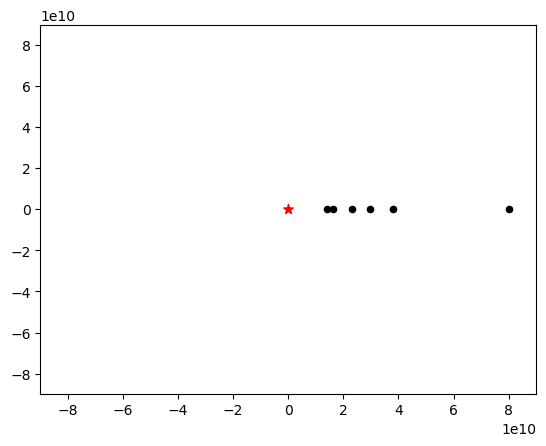

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

IndexError: index 400 is out of bounds for axis 0 with size 400

In [46]:
r0_sol = sol0[:400,:2]
r1_sol = sol1[:400,:2]
r2_sol = sol2[:400,:2]
r3_sol = sol3[:400,:2]
r4_sol = sol4[:400,:2]
r5_sol = sol5[:400,:2]

# SAVE AS MP4 (will be saved in whatever directory you are working in)
fig, ax = plt.subplots()

with writer.saving(fig, "simple_orbit.mp4", dpi=200):
    for i in range(len(time_span)):

        ax.clear()
        #PLANETS
        ax.plot(r0_sol[:i,0],r0_sol[:i,1],color="brown", alpha=0.5)
        ax.scatter(r0_sol[i,0],r0_sol[i,1],color="black",marker="o",s=20, zorder=5)
        
        ax.plot(r1_sol[:i,0],r1_sol[:i,1],color="orange", alpha=0.5)
        ax.scatter(r1_sol[i,0],r1_sol[i,1],color="black",marker="o",s=20, zorder=5)
        
        ax.plot(r2_sol[:i,0],r2_sol[:i,1],color="yellow", alpha=0.5)
        ax.scatter(r2_sol[i,0],r2_sol[i,1],color="black",marker="o",s=20, zorder=5)
        
        ax.plot(r3_sol[:i,0],r3_sol[:i,1],color="green", alpha=0.5)
        ax.scatter(r3_sol[i,0],r3_sol[i,1],color="black",marker="o",s=20, zorder=5)
        
        ax.plot(r4_sol[:i,0],r4_sol[:i,1],color="blue", alpha=0.5)
        ax.scatter(r4_sol[i,0],r4_sol[i,1],color="black",marker="o",s=20, zorder=5)
        
        ax.plot(r5_sol[:i,0],r5_sol[:i,1],color="pink", alpha=0.5)
        ax.scatter(r5_sol[i,0],r5_sol[i,1],color="black",marker="o",s=20, zorder=5)
        
        ##################
        
        ax.scatter(0, 0, color="red",marker="*",s=50, zorder=5) # star
        
        ax.set_xlim(-9e10, 9e10)
        ax.set_ylim(-9e10, 9e10)
        
        plt.draw()
        plt.pause(0.008)
        writer.grab_frame()

In [9]:
pl[0].PMass

Unit("1.9 earthMass")

In [10]:
(ri * 2*np.pi) / pl[0].OrbPer.to(u.s)

<Quantity 491437.88312432>

In [11]:
pl[0].PMass.to(u.kg)

1.134711894880362e+25

In [12]:
x = planets.simple_radii(pl[0])

In [13]:
x.to(u.au) # NOTE: Using the simple radii function I'm abler to get the same values from NASA! :))

<Quantity 0.09141677 AU>

In [14]:
r1 = [0,1]
v1 = [1,1]

#cent_uvec = -np.cross(v1, [0, 0, np.cross(v1,r1)])
#cent_uvec
x =cent_accel(r1, v1)
x = np.array([x[0],x[1]])
print(x)

[-1.  1.]


In [15]:
for i in range(0,6):
    print(pl[i].OrbEcc)

0.045
0.026
0.004
0.012
0.013
0.15


In [16]:
grav_accel([-1,-1], 4e11)

array([-9.43888558, -9.43888558])

In [17]:
# More luke tests
grav_accel(np.array([-1, -1]), 4e11)

array([-9.43888558, -9.43888558])